# tSNE plots using ingredients

In [1]:
import sys
sys.path.append('../eda')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.manifold import TSNE
import itertools
from utils import *

#### Read data and compute "bag of ingredient"

In [2]:
skin_care_df = pd.read_csv('../data_cleaning/skin_care_cleaned.csv')
df = skin_care_df.loc[~skin_care_df['ingredient'].isnull()]

ingredient_count_df = get_matching_ingredient_count(df)
ingredient_count_df.head()

,Melissa officinalis,Mahonia aquifolium root extract,magnesium stearate,sericin,Oenothera biennis oil,GLA,cysteine,Psidium guajava fruit extract,Hydrastis canadenis,cranberry seed extract,...,propylene glycol laurate,coconut acid,pansy extract,biotin,Arctium majus,poloxamers,disodium lauriminodipropionate tocopheryl phosphates,behenyl alcohol,thioctic acid,resveratrol
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### tNSE using all ingredient binary count

In [3]:
model = TSNE(random_state=777, verbose=1)
tsne_vec = model.fit_transform(ingredient_count_df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5206 samples in 0.294s...
[t-SNE] Computed neighbors for 5206 samples in 64.566s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5206
[t-SNE] Computed conditional probabilities for sample 2000 / 5206
[t-SNE] Computed conditional probabilities for sample 3000 / 5206
[t-SNE] Computed conditional probabilities for sample 4000 / 5206
[t-SNE] Computed conditional probabilities for sample 5000 / 5206
[t-SNE] Computed conditional probabilities for sample 5206 / 5206
[t-SNE] Mean sigma: 1.054968
[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.055748
[t-SNE] Error after 1000 iterations: 2.611009


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


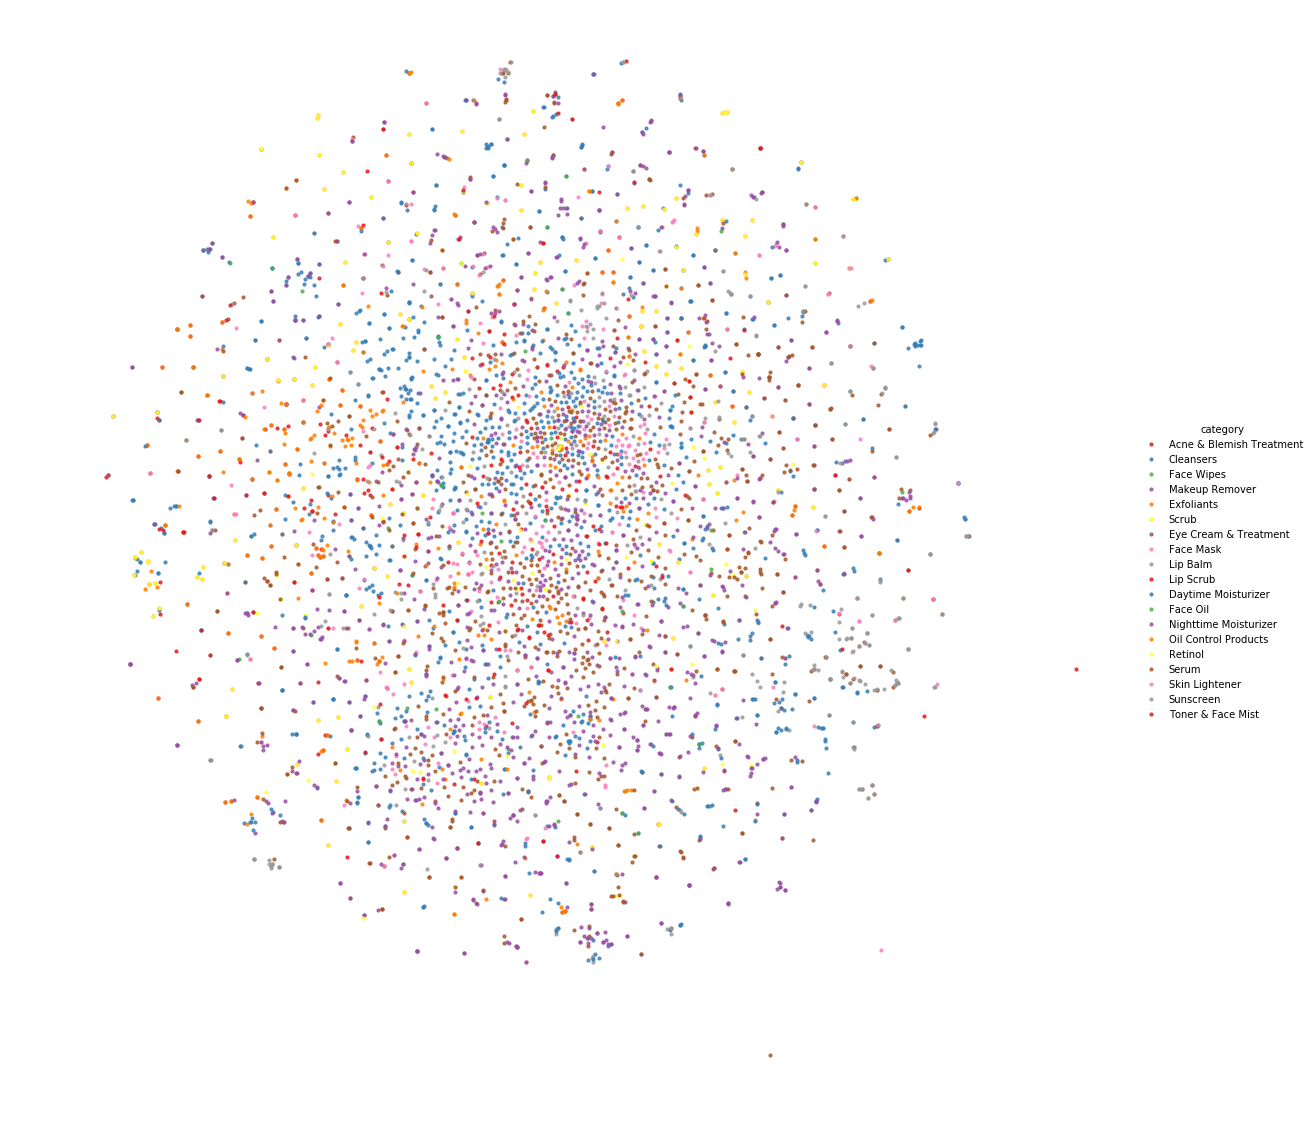

In [4]:
x, y = tsne_vec[:,0], tsne_vec[:,1]
tsne_df = pd.DataFrame()
tsne_df['x'] = x
tsne_df['y'] = y
tsne_df['category'] = df['product_category']
sns.lmplot(x='x', y='y', hue='category', data=tsne_df, fit_reg=False, scatter_kws={"s": 10}, size=16, palette='Set1')
plt.axis('off')
plt.show()

#### tSNE using other ingredient info (rating, category count)

In [5]:
ingredient_df_short = pd.concat([df[['n_inactive_ingredient','n_active_ingredient']].reset_index(drop=True), 
           df.loc[:,'inactive_rating_count_0.0':].reset_index(drop=True)], axis=1)
ingredient_df_short['active_mean_rating'].fillna(-1, inplace=True)

In [6]:
model = TSNE(random_state=777, verbose=1)
tsne_vec2 = model.fit_transform(ingredient_df_short)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5206 samples in 0.012s...
[t-SNE] Computed neighbors for 5206 samples in 1.143s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5206
[t-SNE] Computed conditional probabilities for sample 2000 / 5206
[t-SNE] Computed conditional probabilities for sample 3000 / 5206
[t-SNE] Computed conditional probabilities for sample 4000 / 5206
[t-SNE] Computed conditional probabilities for sample 5000 / 5206
[t-SNE] Computed conditional probabilities for sample 5206 / 5206
[t-SNE] Mean sigma: 3.182910
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.195969
[t-SNE] Error after 1000 iterations: 1.545540


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


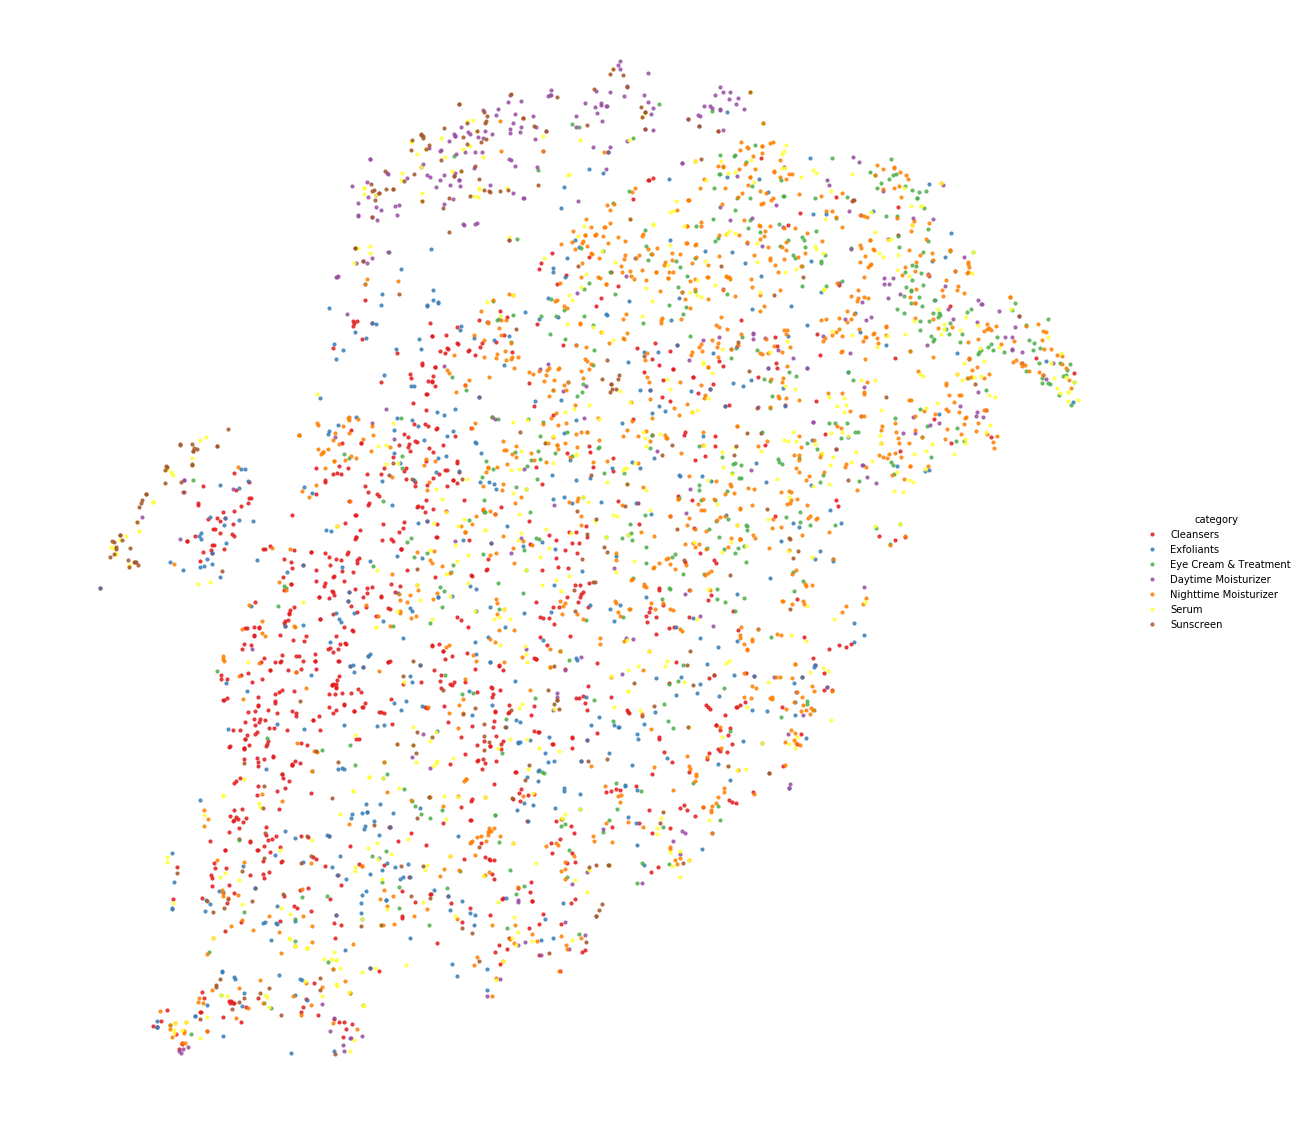

In [7]:
x, y = tsne_vec2[:,0], tsne_vec2[:,1]
tsne_df = pd.DataFrame()
tsne_df['x'] = x
tsne_df['y'] = y
tsne_df['category'] = df['product_category']
tsne_df['category'].fillna('unknown', inplace=True)
#mks = itertools.cycle(['o', 'x', '^', '+', '*', '8', 's', 'p', 'D'])
#markers = [next(mks) for i in tsne_df["category"].unique()]
large_categories = ['Nighttime Moisturizer', 'Cleansers', 'Serum','Exfoliants', 
                    'Eye Cream & Treatment', 'Daytime Moisturizer',
                    'Sunscreen']
sns.lmplot(x='x', y='y', hue='category', data=tsne_df.loc[tsne_df.category.isin(large_categories)], 
           fit_reg=False, scatter_kws={"s": 10}, size=16, palette='Set1')
plt.axis('off')
plt.show()

#### tSNE using other ingredient info (rating, category count) and selected individule ingredient (by chi2)

In [8]:
from sklearn.feature_selection import chi2
chi2s, p_values = chi2(ingredient_count_df, df['product_category'])
feature_p_values = pd.Series(p_values, index = ingredient_count_df.columns.values)
print(feature_p_values.sort_values().head(20))
column_filter = feature_p_values < 1e-10
print("number of selected features:", column_filter.sum())

ingredient_df = pd.concat([df[['n_inactive_ingredient','n_active_ingredient']].reset_index(drop=True), 
           df.loc[:,'inactive_rating_count_0.0':].reset_index(drop=True),
           ingredient_count_df.loc[:,column_filter]], axis=1)
ingredient_df['active_mean_rating'].fillna(-1, inplace=True)
ingredient_df.shape

octocrylene                 0.000000e+00
octisalate                  0.000000e+00
avobenzone                  0.000000e+00
homosalate                 8.718437e-302
oxybenzone                 6.542819e-285
flavor                     1.781151e-273
octinoxate                 6.103882e-271
Ricinus communis           1.148250e-228
salicylic acid             2.859823e-180
red 27 lake                6.282117e-179
cocamidopropyl betaine     1.980453e-152
kaolin                     6.299663e-149
dimethicone                4.140245e-148
retinol                    2.959603e-135
hydroquinone               6.062130e-126
zinc oxide                 6.544968e-111
glycolic acid              2.672889e-108
triethoxycaprylylsilane    2.015790e-104
Copernicia cerifera wax    1.135368e-103
sodium laureth sulfate      2.722145e-99
dtype: float64
number of selected features: 246


(5206, 312)

In [9]:
model = TSNE(random_state=777, verbose=1)
tsne_vec3 = model.fit_transform(ingredient_df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5206 samples in 0.034s...
[t-SNE] Computed neighbors for 5206 samples in 5.844s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5206
[t-SNE] Computed conditional probabilities for sample 2000 / 5206
[t-SNE] Computed conditional probabilities for sample 3000 / 5206
[t-SNE] Computed conditional probabilities for sample 4000 / 5206
[t-SNE] Computed conditional probabilities for sample 5000 / 5206
[t-SNE] Computed conditional probabilities for sample 5206 / 5206
[t-SNE] Mean sigma: 3.310095
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.623512
[t-SNE] Error after 1000 iterations: 1.556473


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


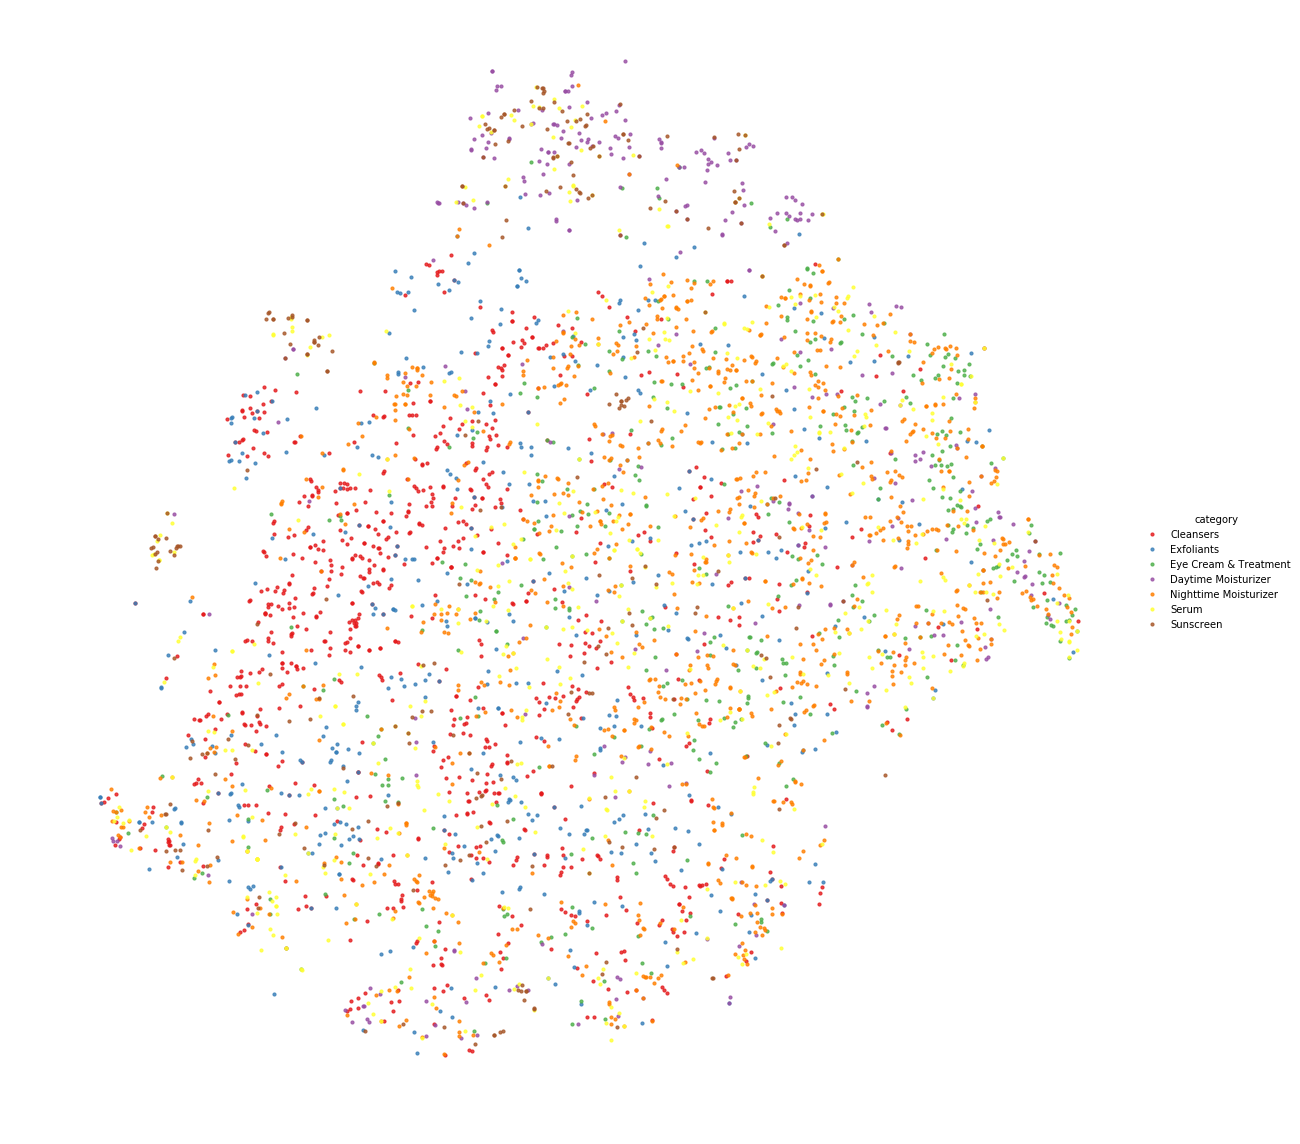

In [10]:
x, y = tsne_vec3[:,0], tsne_vec3[:,1]
tsne_df = pd.DataFrame()
tsne_df['x'] = x
tsne_df['y'] = y
tsne_df['category'] = df['product_category']
tsne_df['category'].fillna('unknown', inplace=True)
#mks = itertools.cycle(['o', 'x', '^', '+', '*', '8', 's', 'p', 'D'])
#markers = [next(mks) for i in tsne_df["category"].unique()]
large_categories = ['Nighttime Moisturizer', 'Cleansers', 'Serum','Exfoliants', 
                    'Eye Cream & Treatment', 'Daytime Moisturizer',
                    'Sunscreen']
sns.lmplot(x='x', y='y', hue='category', data=tsne_df.loc[tsne_df.category.isin(large_categories)], 
           fit_reg=False, scatter_kws={"s": 10}, size=16, palette='Set1')
plt.axis('off')
plt.show()